<a href="https://colab.research.google.com/github/oicr-gsi/debarcer/blob/master/heartDisease_featureSelection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
!pip install prince

In [0]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
# import random
import scipy.stats as stats
# import mca
import prince
import warnings
warnings.filterwarnings('ignore')

In [0]:
# Read in data from website
df_pc = pd.read_csv("https://archive.ics.uci.edu/ml/machine-learning-databases/heart-disease/processed.cleveland.data", names=['age', 'sex', 'cp','trestbps','chol','fbs','restecg','thalach','exang','oldpeak','slope','ca','thal','num'])

In [38]:
df_pc.dtypes

age         float64
sex         float64
cp          float64
trestbps    float64
chol        float64
fbs         float64
restecg     float64
thalach     float64
exang       float64
oldpeak     float64
slope       float64
ca           object
thal         object
num           int64
dtype: object

In [0]:
# Map multiple categories of disease to a new feature, 'target ', which is either 'healthy' or 'heart_disease'
# Map 'sex' to new column 'female' or 'male'
df_pc['target'] = df_pc.num.map({0: 'healthy', 1: 'heart_disease', 2: 'heart_disease', 3: 'heart_disease', 4: 'heart_disease'})
df_pc['sex_str'] = df_pc.sex.map({0: 'female', 1: 'male'})

In [40]:
# There are 4 rows with '?' in 'ca'
df_pc['ca'].value_counts()

0.0    176
1.0     65
2.0     38
3.0     20
?        4
Name: ca, dtype: int64

In [41]:
# There are 2 rows with 'thal' in 'ca'
df_pc['thal'].value_counts()

3.0    166
7.0    117
6.0     18
?        2
Name: thal, dtype: int64

In [0]:
# drop rows where there is a '?' for 'ca' or 'thal'. 
df_pc.drop(df_pc[df_pc['ca']=='?'].index, inplace=True)
df_pc.drop(df_pc[df_pc['thal']=='?'].index, inplace=True)

df_pc['ca'] = pd.to_numeric(df_pc['ca']).astype(int)
df_pc['thal'] = pd.to_numeric(df_pc['thal']).astype(int)

In [0]:
# change datatypes to numeric
df_pc = df_pc.astype({'age':'int64','sex':'int64', 'cp':'int64','trestbps':'int64','chol':'float64', 'fbs':'int64',
              'restecg':'int64','thalach':'int64','exang':'int64','oldpeak':'float64','slope':'int64',
              'ca':'int64','thal':'int64','num':'int64'})

# most of the data is categorical
# set appropriate features to 'category'
df_pc = df_pc.astype({'sex':'category', 'cp':'category', 'fbs':'category', 'restecg':'category','exang':'category',
                     'ca':'category', 'thal':'category','num':'category','target':'category', 'sex_str':'category'})

In [0]:
# df_pc.dtypes

In [45]:
df_pc.head(2)

,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,num,target,sex_str
0,63,1,1,145,233.0,1,2,150,0,2.3,3,0,6,0,healthy,male
1,67,1,4,160,286.0,0,2,108,1,1.5,2,3,3,2,heart_disease,male


In [46]:
# There are twice as many males in this study as there are females
df_pc.groupby(['sex_str']).count()

,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,num,target
sex_str,,,,,,,,,,,,,,,
female,96,96,96,96,96,96,96,96,96,96,96,96,96,96,96
male,201,201,201,201,201,201,201,201,201,201,201,201,201,201,201


In [47]:
# roughly a quarter of the individuals with heart disease are female
df_pc.groupby(['target','sex_str']).count()

age  sex   cp  trestbps  ...  slope   ca  thal  num
target        sex_str                           ...                       
healthy       female    71   71   71        71  ...     71   71    71   71
              male      89   89   89        89  ...     89   89    89   89
heart_disease female    25   25   25        25  ...     25   25    25   25
              male     112  112  112       112  ...    112  112   112  112

[4 rows x 14 columns]

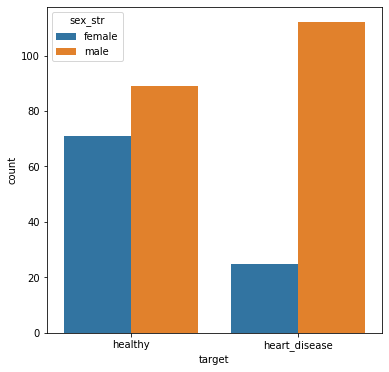

In [48]:
plt.rcParams['figure.figsize'] = 6,6
sns.countplot(x = 'target', hue='sex_str', data = df_pc)

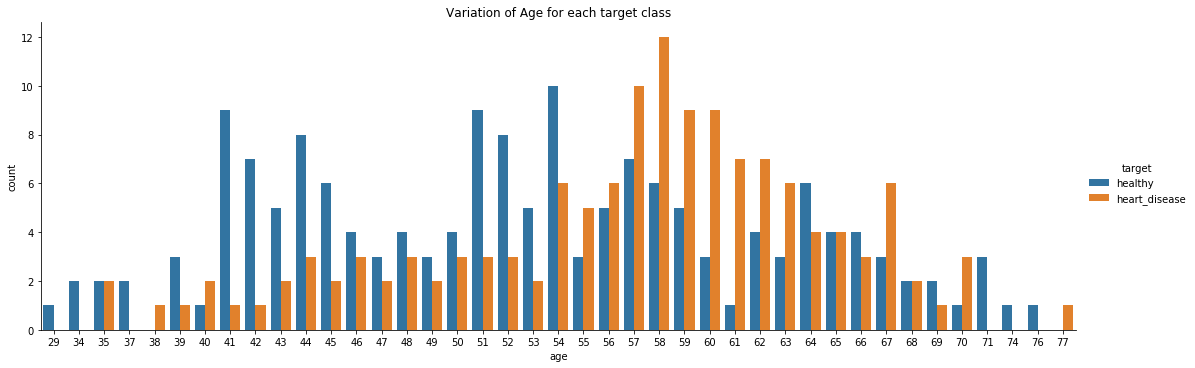

In [49]:
sns.catplot(kind = 'count', 
            data = df_pc, 
            x = 'age', 
            hue = 'target', 
            order = df_pc['age'].sort_values().unique(), 
            height=5, 
            aspect =3)
plt.title('Variation of Age for each target class')
plt.show()

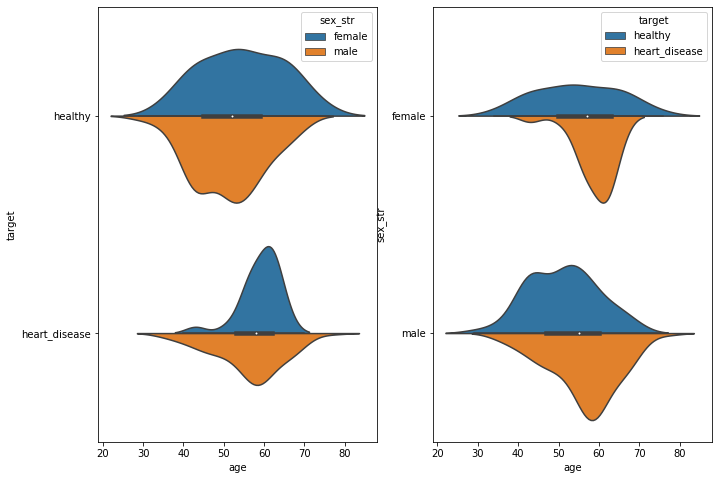

In [50]:
plt.rcParams['figure.figsize'] = 11,8
plt.subplot(121)
sns.violinplot(x='age', y='target',
               hue='sex_str',
               data=df_pc,
               split=True)
plt.subplot(122)
sns.violinplot(x='age', y='sex_str',
               hue='target',
               data=df_pc,
               split=True)

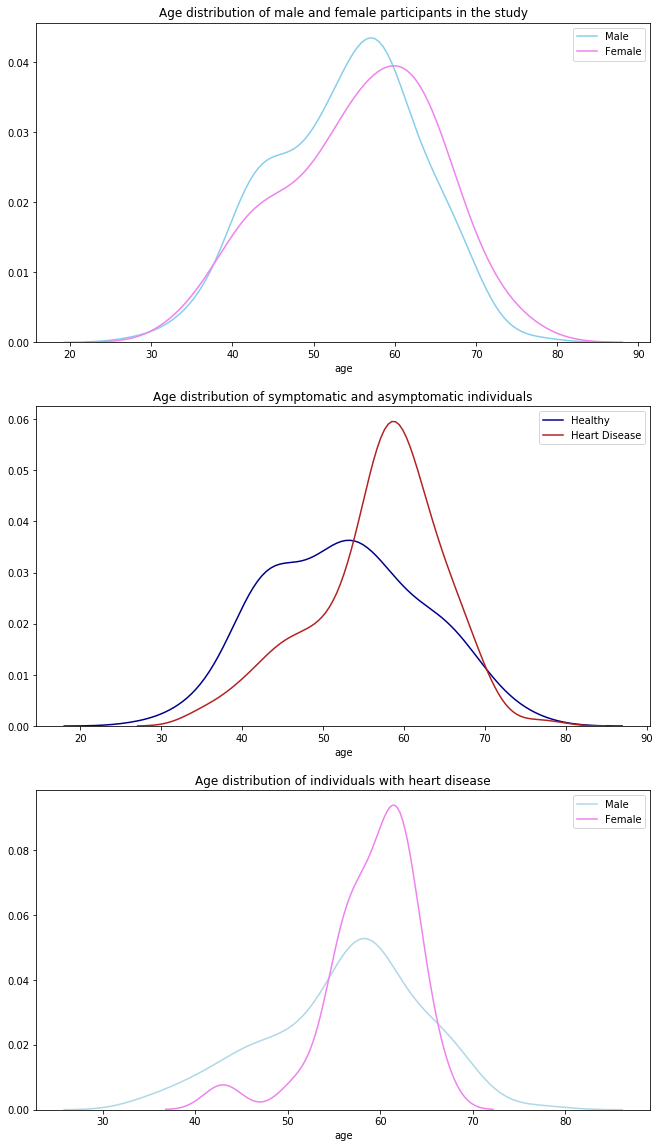

In [51]:
plt.rcParams['figure.figsize'] = 11,20

plt.subplot(311)
plt.title("Age distribution of male and female participants in the study")
sns.distplot(df_pc[df_pc['sex_str']=='male'].age, color = 'skyblue', hist=False, label='Male')
sns.distplot(df_pc[df_pc['sex_str']=='female'].age, color = 'violet', hist=False, label='Female')

plt.subplot(312)
plt.title("Age distribution of symptomatic and asymptomatic individuals")
sns.distplot(df_pc[df_pc['target']=='healthy'].age, color = 'darkblue', hist=False, label='Healthy')
sns.distplot(df_pc[df_pc['target']=='heart_disease'].age, color = 'firebrick', hist=False, label='Heart Disease')

plt.subplot(313)
plt.title("Age distribution of individuals with heart disease")
sns.distplot(df_pc[(df_pc['target']=='heart_disease') & (df_pc['sex_str']=='male')].age, color = 'lightblue', hist=False, label='Male')
sns.distplot(df_pc[(df_pc['target']=='heart_disease') & (df_pc['sex_str']=='female')].age, color = 'violet', hist=False, label='Female')

### Factor Analysis of Mixed Data

In [0]:
famd = prince.FAMD(n_components=2,n_iter=3,copy=True,check_input=True,engine='auto',random_state=42)

famd = famd.fit(df_pc.drop(['target','num','sex_str'], axis='columns'))  # No need for 'Oak type'

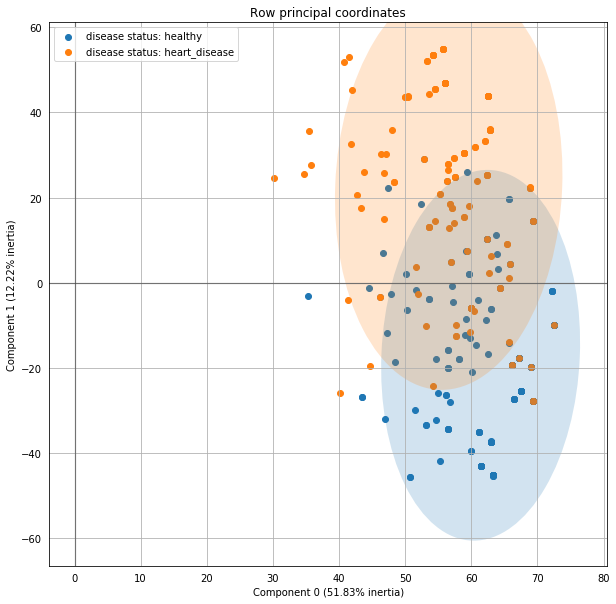

In [53]:
ax = famd.plot_row_coordinates(df_pc,ax=None,
                               figsize=(10, 10),
                               x_component=0,
                               y_component=1,
#                                labels=df_pc.index,
                               color_labels=['disease status: {}'.format(t) for t in df_pc['target']],
                               ellipse_outline=False,
                               ellipse_fill=True,
                               show_points=True)

In [0]:
# famd.row_coordinates(df_pc)

### Feature Selection with chi-squared test using sklearn

In [0]:
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import chi2

In [56]:
df_pc_numeric = df_pc.copy()
df_pc_numeric = df_pc.iloc[:,0:14]
df_pc_numeric = df_pc_numeric.astype({'age':'int64','sex':'int64','cp':'int64','trestbps':'int64',
                                      'chol':'float64', 'fbs':'int64', 'restecg':'int64','thalach':'int64',
                                      'exang':'int64','oldpeak':'float64','slope':'int64','ca':'int64',
                                      'thal':'int64','num':'int64'})
df_pc_numeric.head(2)

,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,num
0,63,1,1,145,233.0,1,2,150,0,2.3,3,0,6,0
1,67,1,4,160,286.0,0,2,108,1,1.5,2,3,3,2


In [0]:
# convert to array for processing
array = df_pc_numeric.values

In [0]:
# set feature and target variable
X = array[:,0:13]
# set target variable
Y = array[:,13]

In [0]:
test = SelectKBest(score_func=chi2, k=5)
fit = test.fit(X, Y)

In [60]:
list=[]
count = 0
for i in fit.scores_:
    list.append((df_pc_numeric.columns[count], i))
    count +=1
list.sort(key=lambda x: x[1], reverse = True)
list

[('thalach', 219.88355659231846),
 ('ca', 107.2135531135531),
 ('oldpeak', 98.50552313475997),
 ('thal', 70.52028293770285),
 ('exang', 39.11918191344738),
 ('chol', 38.16745158529377),
 ('age', 27.975232712608047),
 ('trestbps', 19.348089994529833),
 ('cp', 16.383180472246295),
 ('restecg', 13.026433722527464),
 ('slope', 10.17842079139348),
 ('sex', 7.511646096440868),
 ('fbs', 6.778461219013544)]

#### It appears the 4 strongest predictors of heart disease are: <br>
1. thalach - The maximum heart rate of a patient<br>
2. ca - The number of major vessels colored by fluoroscopy<br>
3. oldpeak - The ST depression on a patients ecg during exercise<br>
4. thal - the defect type: 3 - normal, 6 - fixed defect, 7 - reversible defect<br>

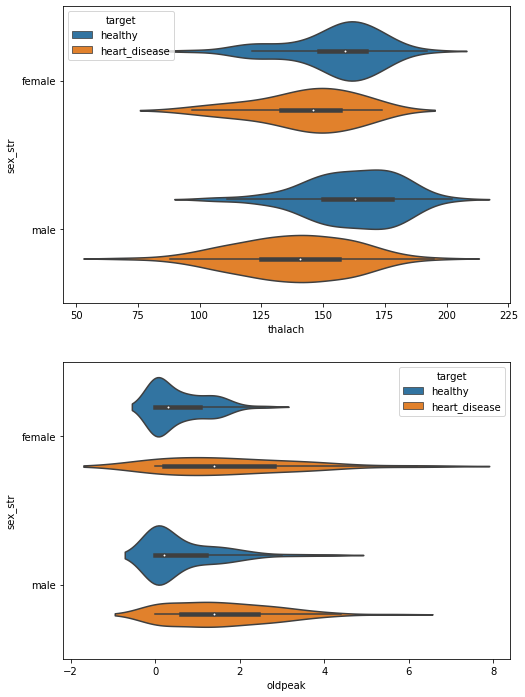

In [61]:
plt.rcParams['figure.figsize'] = 8,12

plt.subplot(211)
sns.violinplot(x='thalach', y='sex_str', 
               hue='target', 
               data=df_pc)
              
plt.subplot(212)
sns.violinplot(x='oldpeak', y='sex_str', 
               hue='target', 
               data=df_pc)
#               split=True

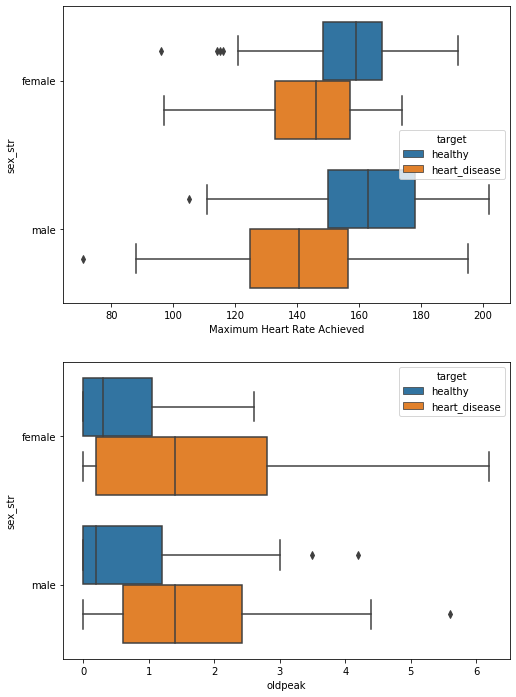

In [62]:
plt.rcParams['figure.figsize'] = 8,12

plt.subplot(211)
sns.boxplot(x='thalach', y='sex_str', 
               hue='target', 
               data=df_pc)
plt.xlabel('Maximum Heart Rate Achieved')
              
plt.subplot(212)
sns.boxplot(x='oldpeak', y='sex_str', 
               hue='target', 
               data=df_pc)
#               split=True


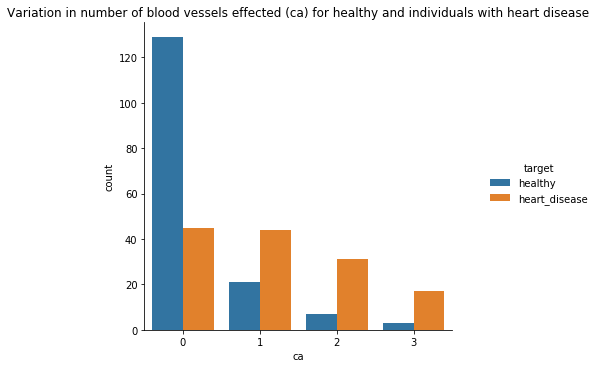

In [63]:
sns.catplot(kind = 'count', 
            data = df_pc, 
            x = 'ca', 
            hue = 'target', 
            order = df_pc['ca'].sort_values().unique(), 
            height=5, 
            aspect =1)
plt.title('Variation in number of blood vessels effected (ca) for healthy and individuals with heart disease')
plt.show()


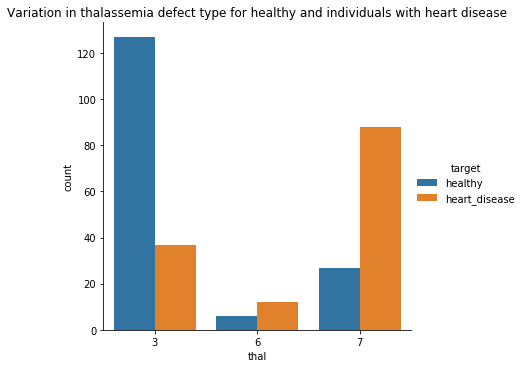

In [64]:
sns.catplot(kind = 'count', 
            data = df_pc, 
            x = 'thal', 
            hue = 'target', 
            order = df_pc['thal'].sort_values().unique(), 
            height=5, 
            aspect =1)
plt.title('Variation in thalassemia defect type for healthy and individuals with heart disease')
plt.show()


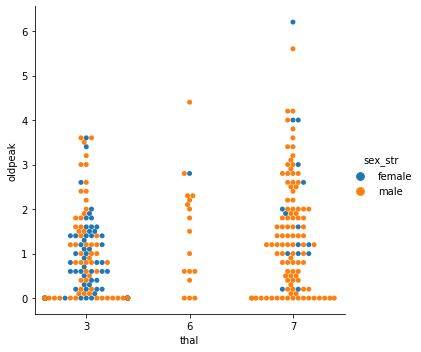

In [65]:
sns.catplot(x="thal", y="oldpeak", hue="sex_str", kind="swarm", data=df_pc)

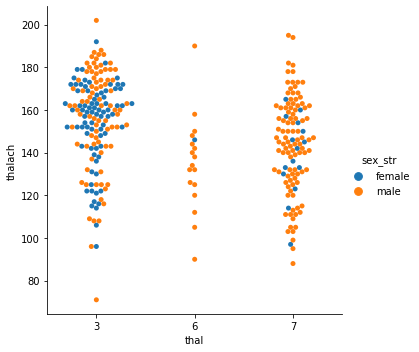

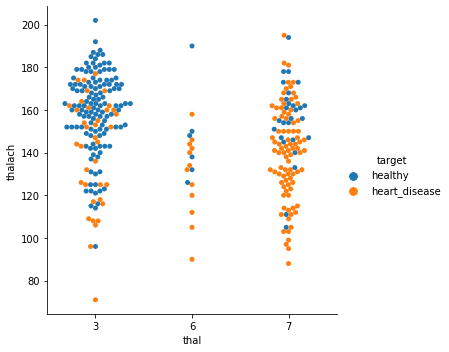

In [66]:
sns.catplot(x="thal", y="thalach", hue="sex_str", kind="swarm", data=df_pc)
sns.catplot(x="thal", y="thalach", hue="target", kind="swarm", data=df_pc)

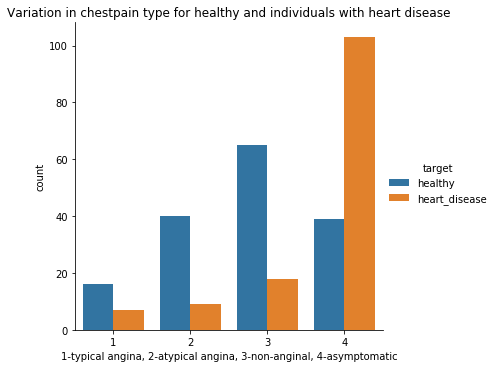

In [67]:
# chestpain type appears to be a good predictor of heart disease but was ranked below the other features
sns.catplot(kind = 'count', 
            data = df_pc, 
            x = 'cp', 
            hue = 'target', 
            order = df_pc['cp'].sort_values().unique(), 
            height=5, 
            aspect =1)
plt.xlabel('1-typical angina, 2-atypical angina, 3-non-anginal, 4-asymptomatic')
plt.title('Variation in chestpain type for healthy and individuals with heart disease')
plt.show()


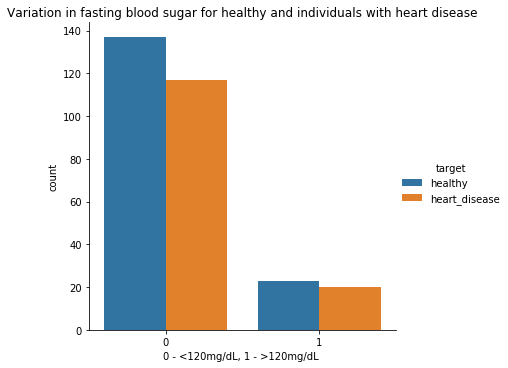

In [68]:
# fasting blood sugar is not a strong predictor of heart disease as suggested from the above analysis
sns.catplot(kind = 'count', 
            data = df_pc, 
            x = 'fbs', 
            hue = 'target', 
            order = df_pc['fbs'].sort_values().unique(), 
            height=5, 
            aspect =1)
plt.xlabel('0 - <120mg/dL, 1 - >120mg/dL ')
plt.title('Variation in fasting blood sugar for healthy and individuals with heart disease')
plt.show()